## **Layer Normalization**

In [1]:
import torch

from torch import nn

In [2]:
torch.manual_seed(123)

batch_example=torch.randn(2,5)

layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())

In [3]:
out=layer(batch_example)

print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [4]:
mean=out.mean(dim=-1,keepdim=True)
var=out.var(dim=-1,keepdim=True)

print(f"Mean: \n {mean}\n\n Variance: \n {var}")

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

 Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [5]:
out_norm=(out-mean)/torch.sqrt(var)

mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)

print(f"Mean: \n {mean}\n\n Variance: \n {var}")

Mean: 
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)

 Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [6]:
torch.set_printoptions(sci_mode=False)

mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)

print(f"Mean: \n {mean}\n\n Variance: \n {var}")

Mean: 
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)

 Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
## Implemented
# class LayerNorm(nn.Module):
#     def __init__(self,emb_dim):
#         super().__init__()
#         self.eps=1e-5
#         self.scale=nn.Parameter(torch.ones(emb_dim))
#         self.shift=nn.Parameter(torch.zeros(emb_dim))
    
#     def forward(self,x):
#         mean=x.mean(dim=-1,keepdim=True)
#         var=x.var(dim=-1,keepdim=True,unbiased=False)
#         norm_x=(x-mean)/torch.sqrt(var+self.eps)
#         return norm_x * self.scale+ self.shift

## Optimized and Production Level

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) * torch.rsqrt(var + self.eps)
        return norm_x * self.scale + self.shift

In [8]:
ln=LayerNorm(emb_dim=5)

In [9]:
out_ln=ln(batch_example)

In [11]:
out_ln.var(dim=-1,keepdim=True,unbiased=False)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

## **GELU Activation**

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

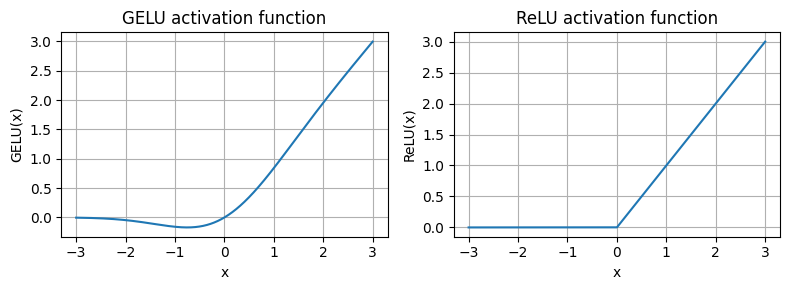

In [25]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 10000)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

## **Feed Forward Network**

In [33]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(),                                       ## Activation
            nn.Linear(4 * cfg["emb_dim"],cfg["emb_dim"]), ## Contraption
        )
    def forward(self,x):
        return self.layers(x)

In [28]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [29]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [34]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)

out=ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [35]:
out

tensor([[[ 0.0690,  0.0182,  0.1926,  ..., -0.0138,  0.0572,  0.0565],
         [ 0.0435,  0.0449,  0.1274,  ...,  0.0164,  0.0683,  0.0678],
         [ 0.0182,  0.0070,  0.2218,  ..., -0.0497, -0.0290, -0.0344]],

        [[ 0.0819,  0.0783,  0.1352,  ..., -0.1164,  0.0209,  0.0144],
         [ 0.0049,  0.0655,  0.1620,  ..., -0.0470,  0.0451, -0.0401],
         [ 0.0366,  0.0251,  0.1607,  ..., -0.0104, -0.0240,  0.0845]]],
       grad_fn=<ViewBackward0>)

## **Shortcut Connections**